<a href="https://colab.research.google.com/github/KatieMarsh/STONK/blob/main/new_stock_prediction_LSTM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load and preprocess data**

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

!pip install pandas_datareader
from pandas_datareader import data as pdr
from tqdm import tqdm_notebook

stock_list = ['KBANK','SCB','BBL','KTB']
stock_data = []
stock_name = []
for quote in tqdm_notebook(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo(f'{quote}.BK', start='1990-01-01', end='2019-01-01'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [308]:
!pip install bta-lib #try this out
import btalib

In [309]:
#this part extract indicator from data

sma = btalib.sma(stock_data[0].Close, period=20)  # default period is 30, changed to 20
sma.df.columns = ['SMA']

t3 = btalib.t3(stock_data[0], period=5)
t3.df.columns = ['t3']

# atr = btalib.natr(stock_data[0].High,stock_data[0].Low,stock_data[0].Close, period=7)
# atr.df.columns = ['atr']

stock_data = pd.concat([stock_data[0],sma.df,t3.df],axis=1) #concat them
# stock_data = pd.concat([stock_data[0],wma.df],axis=1)

In [310]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    
# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
dataset = stock_data
# dataset = stock_data[0]
dataset = dataset.drop('Close',axis=1)
dataset['pct_change'] = dataset['Adj Close'].pct_change().dropna()
values = dataset.values
values = values.astype('float32')


# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
#I think this part can be replaced with sigmoid
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
  


# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 30, 1,feat_name=dataset.columns)

# reframed.drop(['High(t)','Low(t)','Open(t)','Volume(t)','Adj Close(t)'],
              # axis=1,inplace=True)#แก้ตรงนี้

reframed.drop(['High(t)','Low(t)','Open(t)','Volume(t)','Adj Close(t)','SMA(t)','t3(t)'],
              axis=1,inplace=True)#แก้ตรงนี้

# for i in range(1, 30, 1):
#     reframed.drop([f'High(t+{i})',f'Low(t+{i})',f'Open(t+{i})',f'Volume(t+{i})',f'Adj Close(t+{i})'],
#               axis=1,inplace=True)




In [368]:
dataset.head(5)

,High,Low,Open,Volume,Adj Close,SMA,t3,pct_change
Date,,,,,,,,
2000-01-04,0.128286,0.128587,0.127637,0.211803,0.098518,NaN,NaN,NaN
2000-01-05,0.120925,0.117960,0.119198,0.324000,0.089635,NaN,NaN,0.400473
2000-01-06,0.116719,0.113709,0.118143,0.163759,0.086405,NaN,NaN,0.524097
2000-01-07,0.120925,0.115834,0.114979,0.120387,0.092865,NaN,NaN,0.762658
2000-01-10,0.126183,0.122210,0.125527,0.154479,0.092865,NaN,NaN,0.602337


In [312]:
reframed.head(10)

,High(t-30),Low(t-30),Open(t-30),Volume(t-30),Adj Close(t-30),SMA(t-30),t3(t-30),pct_change(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),Adj Close(t-29),SMA(t-29),t3(t-29),pct_change(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),Adj Close(t-28),SMA(t-28),t3(t-28),pct_change(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),Adj Close(t-27),SMA(t-27),t3(t-27),pct_change(t-27),High(t-26),Low(t-26),Open(t-26),Volume(t-26),Adj Close(t-26),SMA(t-26),t3(t-26),pct_change(t-26),High(t-25),Low(t-25),Open(t-25),Volume(t-25),Adj Close(t-25),SMA(t-25),t3(t-25),pct_change(t-25),High(t-24),Low(t-24),Open(t-24),Volume(t-24),Adj Close(t-24),SMA(t-24),t3(t-24),pct_change(t-24),High(t-23),Low(t-23),Open(t-23),Volume(t-23),Adj Close(t-23),SMA(t-23),t3(t-23),pct_change(t-23),High(t-22),Low(t-22),Open(t-22),Volume(t-22),Adj Close(t-22),SMA(t-22),t3(t-22),pct_change(t-22),High(t-21),Low(t-21),Open(t-21),Volume(t-21),Adj Close(t-21),SMA(t-21),t3(t-21),pct_change(t-21),High(t-20),Low(t-20),Open(t-20),Volume(t-20),Adj Close(t-20),SMA(t-20),t3(t-20),pct_change(t-20),High(t-19),Low(t-19),Open(t-19),Volume(t-19),Adj Close(t-19),SMA(t-19),t3(t-19),pct_change(t-19),High(t-18),Low(t-18),Open(t-18),Volume(t-18),Adj Close(t-18),SMA(t-18),t3(t-18),pct_change(t-18),High(t-17),Low(t-17),Open(t-17),Volume(t-17),Adj Close(t-17),SMA(t-17),t3(t-17),pct_change(t-17),High(t-16),Low(t-16),Open(t-16),Volume(t-16),Adj Close(t-16),SMA(t-16),t3(t-16),pct_change(t-16),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-15),SMA(t-15),t3(t-15),pct_change(t-15),High(t-14),Low(t-14),Open(t-14),Volume(t-14),Adj Close(t-14),SMA(t-14),t3(t-14),pct_change(t-14),High(t-13),Low(t-13),Open(t-13),Volume(t-13),Adj Close(t-13),SMA(t-13),t3(t-13),pct_change(t-13),High(t-12),Low(t-12),Open(t-12),Volume(t-12),Adj Close(t-12),SMA(t-12),t3(t-12),pct_change(t-12),High(t-11),Low(t-11),Open(t-11),Volume(t-11),Adj Close(t-11),SMA(t-11),t3(t-11),pct_change(t-11),High(t-10),Low(t-10),Open(t-10),Volume(t-10),Adj Close(t-10),SMA(t-10),t3(t-10),pct_change(t-10),High(t-9),Low(t-9),Open(t-9),Volume(t-9),Adj Close(t-9),SMA(t-9),t3(t-9),pct_change(t-9),High(t-8),Low(t-8),Open(t-8),Volume(t-8),Adj Close(t-8),SMA(t-8),t3(t-8),pct_change(t-8),High(t-7),Low(t-7),Open(t-7),Volume(t-7),Adj Close(t-7),SMA(t-7),t3(t-7),pct_change(t-7),High(t-6),Low(t-6),Open(t-6),Volume(t-6),Adj Close(t-6),SMA(t-6),t3(t-6),pct_change(t-6),High(t-5),Low(t-5),Open(t-5),Volume(t-5),Adj Close(t-5),SMA(t-5),t3(t-5),pct_change(t-5),High(t-4),Low(t-4),Open(t-4),Volume(t-4),Adj Close(t-4),SMA(t-4),t3(t-4),pct_change(t-4),High(t-3),Low(t-3),Open(t-3),Volume(t-3),Adj Close(t-3),SMA(t-3),t3(t-3),pct_change(t-3),High(t-2),Low(t-2),Open(t-2),Volume(t-2),Adj Close(t-2),SMA(t-2),t3(t-2),pct_change(t-2),High(t-1),Low(t-1),Open(t-1),Volume(t-1),Adj Close(t-1),SMA(t-1),t3(t-1),pct_change(t-1),pct_change(t)
54,0.117771,0.117960,0.116034,0.043713,0.089635,0.123591,0.118408,0.622014,0.116719,0.115834,0.118143,0.038910,0.087213,0.123372,0.117264,0.543657,0.114616,0.111583,0.116034,0.134156,0.084790,0.122880,0.115896,0.542584,0.109359,0.108395,0.109705,0.125271,0.082368,0.122278,0.114108,0.541469,0.108307,0.105207,0.107595,0.147834,0.079945,0.121293,0.111859,0.540314,0.103049,0.103082,0.102321,0.087172,0.078330,0.120144,0.109326,0.560188,0.104101,0.100956,0.102321,0.082013,0.078330,0.118777,0.106937,0.602337,0.103049,0.103082,0.103376,0.086423,0.078330,0.117409,0.104983,0.602337,0.103049,0.098831,0.103376,0.134525,0.074292,0.115768,0.102945,0.495588,0.097792,0.095643,0.099156,0.161392,0.074292,0.114345,0.100995,0.602337,0.095689,0.098831,0.097046,0.000000,0.074292,0.112923,0.099354,0.602337,0.093586,0.088204,0.094937,0.149969,0.066217,0.111062,0.096892,0.381626,0.091483,0.086079,0.084388,0.103815,0.070255,0.109531,0.094627,0.720689,0.092534,0.089267,0.092827,0.080088,0.068640,0.107725,0.092684,0.556652,0.090431,0.088204,0.088608,0.046612,0.068640,0.105920,0.091183,0.602337,0.087277,0.085016,0.088608,0.087037,0.064602,0.104005,0.089530,0

In [313]:
# split into train and test sets
n_train_percent = 0.9
split = int(reframed.shape[0]*n_train_percent)
df_seq_train = reframed.iloc[:split, :]
df_seq_test = reframed.iloc[split:, :]

date_all = dataset.index[reframed.index]

## Extract features from datetime

In [314]:
df_dt = pd.DataFrame({'date_time':date_all})

In [315]:
df_dt_feat = pd.concat([df_dt.date_time.dt.day, df_dt.date_time.dt.dayofweek, df_dt.date_time.dt.dayofyear,\
                           df_dt.date_time.dt.daysinmonth, df_dt.date_time.dt.is_month_end,df_dt.date_time.dt.is_month_start,\
                           df_dt.date_time.dt.is_quarter_end, df_dt.date_time.dt.is_quarter_start, df_dt.date_time.dt.is_year_end,\
                           df_dt.date_time.dt.is_year_start],axis=1)
df_dt_feat.columns = ['day','dayofweek','dayofyear','daysinmonth','is_month_end','is_month_start','is_quarter_end','is_quarter_start',\
                        'is_year_end','is_year_start']

In [316]:
df_dt_feat['is_month_end'] = df_dt_feat['is_month_end'].astype(int)
df_dt_feat['is_month_start'] = df_dt_feat['is_month_start'].astype(int)
df_dt_feat['is_quarter_end'] = df_dt_feat['is_quarter_end'].astype(int)
df_dt_feat['is_quarter_start'] = df_dt_feat['is_quarter_start'].astype(int)
df_dt_feat['is_year_end'] = df_dt_feat['is_year_end'].astype(int)
df_dt_feat['is_year_start'] = df_dt_feat['is_year_start'].astype(int)

In [317]:
# encode categorical columns
for col in ['day','dayofweek','dayofyear','daysinmonth']:
  df_dt_feat[col] = df_dt_feat[col].astype('category').cat.as_ordered().cat.codes

In [318]:
df_dt_feat.head()

,day,dayofweek,dayofyear,daysinmonth,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,19,0,79,3,0,0,0,0,0,0
1,20,1,80,3,0,0,0,0,0,0
2,21,2,81,3,0,0,0,0,0,0
3,22,3,82,3,0,0,0,0,0,0
4,23,4,83,3,0,0,0,0,0,0


In [319]:
df_dt_feat_train = df_dt_feat.iloc[:split]
df_dt_feat_test = df_dt_feat.iloc[split:]

# **PYTORCH PART**<BR>
**  CREDIT:** Thanks to **Charin Polpanumas** for his tutorial on Recommendation system using Pytorch. Most of this Pytorch part is adapted from his original code.

## Dataset & Dataloader



In [320]:
#torch 
import torch
import torch.onnx as onnx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [321]:
device

device(type='cuda', index=0)

In [322]:
class StockDataset(Dataset):
  def __init__(self, df_seq, feat_num, seq_len, target_len, df_cat):
    # SEQUENTIAL PART
    self.df_seq = df_seq.iloc[:,:-target_len]
    self.df_cat = df_cat
    self.target = df_seq.iloc[:,-target_len:]
    
  def __getitem__(self, index):
    return(torch.tensor(self.df_seq.iloc[index].values.reshape(seq_len,feat_num), dtype=torch.float, device=device),
           torch.tensor(self.df_cat.iloc[index], dtype=torch.long, device=device),
           torch.tensor(self.target.iloc[index], dtype=torch.float, device=device))
  
  def __len__(self):
    return(self.df_seq.shape[0])
    

feat_num = 8 # จำนวน feat
seq_len = 30 # ข้อมูล 30 วัน
target_len = 1

bs = 64
train_ds = StockDataset(df_seq_train, feat_num, seq_len, target_len, df_dt_feat_train) #df_seq_train ลองไปดูถ้าต้องเพิ่มน่าจะตรงนี้
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False, drop_last=True)
test_ds = StockDataset(df_seq_test, feat_num, seq_len, target_len, df_dt_feat_test)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [323]:
next(iter(train_dl))[0]

tensor([[[0.1178, 0.1180, 0.1160,  ..., 0.1236, 0.1184, 0.6220],
         [0.1167, 0.1158, 0.1181,  ..., 0.1234, 0.1173, 0.5437],
         [0.1146, 0.1116, 0.1160,  ..., 0.1229, 0.1159, 0.5426],
         ...,
         [0.0883, 0.0850, 0.0886,  ..., 0.0866, 0.0859, 0.4633],
         [0.0862, 0.0861, 0.0876,  ..., 0.0860, 0.0865, 0.6507],
         [0.0883, 0.0871, 0.0886,  ..., 0.0855, 0.0868, 0.6262]],

        [[0.1167, 0.1158, 0.1181,  ..., 0.1234, 0.1173, 0.5437],
         [0.1146, 0.1116, 0.1160,  ..., 0.1229, 0.1159, 0.5426],
         [0.1094, 0.1084, 0.1097,  ..., 0.1223, 0.1141, 0.5415],
         ...,
         [0.0862, 0.0861, 0.0876,  ..., 0.0860, 0.0865, 0.6507],
         [0.0883, 0.0871, 0.0886,  ..., 0.0855, 0.0868, 0.6262],
         [0.0862, 0.0871, 0.0876,  ..., 0.0849, 0.0871, 0.6023]],

        [[0.1146, 0.1116, 0.1160,  ..., 0.1229, 0.1159, 0.5426],
         [0.1094, 0.1084, 0.1097,  ..., 0.1223, 0.1141, 0.5415],
         [0.1083, 0.1052, 0.1076,  ..., 0.1213, 0.1119, 0.

In [324]:
next(iter(train_dl))[1]

tensor([[ 19,   0,  79,   3,   0,   0,   0,   0,   0,   0],
        [ 20,   1,  80,   3,   0,   0,   0,   0,   0,   0],
        [ 21,   2,  81,   3,   0,   0,   0,   0,   0,   0],
        [ 22,   3,  82,   3,   0,   0,   0,   0,   0,   0],
        [ 23,   4,  83,   3,   0,   0,   0,   0,   0,   0],
        [ 26,   0,  86,   3,   0,   0,   0,   0,   0,   0],
        [ 27,   1,  87,   3,   0,   0,   0,   0,   0,   0],
        [ 28,   2,  88,   3,   0,   0,   0,   0,   0,   0],
        [ 29,   3,  89,   3,   0,   0,   0,   0,   0,   0],
        [ 30,   4,  90,   3,   1,   0,   1,   0,   0,   0],
        [  2,   0,  93,   2,   0,   0,   0,   0,   0,   0],
        [  3,   1,  94,   2,   0,   0,   0,   0,   0,   0],
        [  4,   2,  95,   2,   0,   0,   0,   0,   0,   0],
        [  5,   3,  96,   2,   0,   0,   0,   0,   0,   0],
        [  6,   4,  97,   2,   0,   0,   0,   0,   0,   0],
        [  9,   0, 100,   2,   0,   0,   0,   0,   0,   0],
        [ 10,   1, 101,   2,   0,   0,  

In [325]:
next(iter(train_dl))[2]

tensor([[0.6023],
        [0.6023],
        [0.5550],
        [0.6023],
        [0.6264],
        [0.6739],
        [0.7190],
        [0.5798],
        [0.4662],
        [0.5787],
        [0.6023],
        [0.5070],
        [0.7006],
        [0.6023],
        [0.6739],
        [0.6023],
        [0.6023],
        [0.6490],
        [0.6023],
        [0.6023],
        [0.3953],
        [0.6023],
        [0.6269],
        [0.6023],
        [0.6511],
        [0.6264],
        [0.5785],
        [0.5543],
        [0.6511],
        [0.5543],
        [0.6023],
        [0.5780],
        [0.5532],
        [0.6023],
        [0.6023],
        [0.5275],
        [0.6023],
        [0.3471],
        [0.5747],
        [0.6023],
        [0.4907],
        [0.7469],
        [0.6023],
        [0.4362],
        [0.6607],
        [0.5164],
        [0.5141],
        [0.4511],
        [0.5072],
        [0.6677],
        [0.5383],
        [0.6023],
        [0.8637],
        [0.6931],
        [0.7789],
        [0

In [326]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)
print(next(iter(train_dl))[2].shape)

torch.Size([64, 30, 8])
torch.Size([64, 10])
torch.Size([64, 1])


## **Architecture**

In [327]:
config = {'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len':seq_len, 'rnn_input_dim':feat_num, #จำนวน feat ปัจจุบัน ให้ลอง mod ดู
          'fc_szs':[1000, 500],'fc_ps':[0.5, 0.25], 'out_sz':target_len,
          'emb_p':0.05}
cat_dict = {'day':31,'dayofweek':5,'dayofyear':366,'daysinmonth':4,'is_month_end':2,
            'is_month_start':2,'is_quarter_end':2,'is_quarter_start':2,'is_year_end':2,'is_year_start':2}
  
# lazy embedding size rule!
def emb_sz_rule(n_cat): return min(50,n_cat)


class StockPredictor(nn.Module):
  def __init__(self,config,cat_size):
    super(StockPredictor, self).__init__()
    # set parameters
    self.rnn_p = config['rnn_p']
    self.rnn_l = config['rnn_l']
    self.rnn_h = config['rnn_h']
    self.seq_len = config['seq_len']
    self.fc_szs = config['fc_szs']
    self.fc_ps = config['fc_ps']
    self.out_sz = config['out_sz']
    self.cat_size = cat_size
    self.emb_p  = config['emb_p']
    
    # embedding layers for categorical features
    self.emb_drop = nn.Dropout(self.emb_p)
    self.cat_layers = nn.ModuleList([nn.Embedding(val,emb_sz_rule(val)) for val in cat_size.values()])
    self.lin_in = sum([emb_sz_rule(val) for val in cat_size.values()]) + self.rnn_h*self.seq_len
    self.fc_szs = [self.lin_in] + self.fc_szs
    
    # recurrent layers
    self.rnn_layers = nn.LSTM(config['rnn_input_dim'], self.rnn_h, num_layers=self.rnn_l,
                             bias=True, batch_first=True, dropout=self.rnn_p)
    
    # fully connected layers
    fc_layers_list = []
    for ni, nf, p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
      fc_layers_list.append(nn.Linear(ni, nf))
      fc_layers_list.append(nn.ReLU(inplace=True))
      fc_layers_list.append(nn.BatchNorm1d(nf))
      fc_layers_list.append(nn.Dropout(p=p))
    self.fc_layers = nn.Sequential(*fc_layers_list)
    
    # output
    self.out = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)
    
  def forward(self, seq_input, cat_input):
    # cat
    cat_list = [e(cat_input[:,i]) for i,e in enumerate(self.cat_layers)]
    cat_out = torch.cat(cat_list,1)
    cat_out = self.emb_drop(cat_out)
    
    # seq
    bs = seq_input.shape[0]
    seq_out, seq_h = self.rnn_layers(seq_input)
    seq_out = seq_out.contiguous()
    seq_out = seq_out.view(bs,-1)
    
    #linear
    lin_in = torch.cat([cat_out, seq_out],1)
    res = self.fc_layers(lin_in)
    res = self.out(res)
    
    return res

In [328]:
model = StockPredictor(config,cat_dict).to(device)
x = next(iter(train_dl))
seq_input = x[0]
cat_input = x[1]
model(seq_input, cat_input).shape

torch.Size([64, 1])

In [329]:
cat_input

tensor([[ 19,   0,  79,   3,   0,   0,   0,   0,   0,   0],
        [ 20,   1,  80,   3,   0,   0,   0,   0,   0,   0],
        [ 21,   2,  81,   3,   0,   0,   0,   0,   0,   0],
        [ 22,   3,  82,   3,   0,   0,   0,   0,   0,   0],
        [ 23,   4,  83,   3,   0,   0,   0,   0,   0,   0],
        [ 26,   0,  86,   3,   0,   0,   0,   0,   0,   0],
        [ 27,   1,  87,   3,   0,   0,   0,   0,   0,   0],
        [ 28,   2,  88,   3,   0,   0,   0,   0,   0,   0],
        [ 29,   3,  89,   3,   0,   0,   0,   0,   0,   0],
        [ 30,   4,  90,   3,   1,   0,   1,   0,   0,   0],
        [  2,   0,  93,   2,   0,   0,   0,   0,   0,   0],
        [  3,   1,  94,   2,   0,   0,   0,   0,   0,   0],
        [  4,   2,  95,   2,   0,   0,   0,   0,   0,   0],
        [  5,   3,  96,   2,   0,   0,   0,   0,   0,   0],
        [  6,   4,  97,   2,   0,   0,   0,   0,   0,   0],
        [  9,   0, 100,   2,   0,   0,   0,   0,   0,   0],
        [ 10,   1, 101,   2,   0,   0,  

In [330]:
seq_input

tensor([[[0.1178, 0.1180, 0.1160,  ..., 0.1236, 0.1184, 0.6220],
         [0.1167, 0.1158, 0.1181,  ..., 0.1234, 0.1173, 0.5437],
         [0.1146, 0.1116, 0.1160,  ..., 0.1229, 0.1159, 0.5426],
         ...,
         [0.0883, 0.0850, 0.0886,  ..., 0.0866, 0.0859, 0.4633],
         [0.0862, 0.0861, 0.0876,  ..., 0.0860, 0.0865, 0.6507],
         [0.0883, 0.0871, 0.0886,  ..., 0.0855, 0.0868, 0.6262]],

        [[0.1167, 0.1158, 0.1181,  ..., 0.1234, 0.1173, 0.5437],
         [0.1146, 0.1116, 0.1160,  ..., 0.1229, 0.1159, 0.5426],
         [0.1094, 0.1084, 0.1097,  ..., 0.1223, 0.1141, 0.5415],
         ...,
         [0.0862, 0.0861, 0.0876,  ..., 0.0860, 0.0865, 0.6507],
         [0.0883, 0.0871, 0.0886,  ..., 0.0855, 0.0868, 0.6262],
         [0.0862, 0.0871, 0.0876,  ..., 0.0849, 0.0871, 0.6023]],

        [[0.1146, 0.1116, 0.1160,  ..., 0.1229, 0.1159, 0.5426],
         [0.1094, 0.1084, 0.1097,  ..., 0.1223, 0.1141, 0.5415],
         [0.1083, 0.1052, 0.1076,  ..., 0.1213, 0.1119, 0.

In [331]:
model

StockPredictor(
  (emb_drop): Dropout(p=0.05, inplace=False)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(8, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=30102, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

## **Training**

In [332]:
from copy import deepcopy
model = StockPredictor(config, cat_dict).to(device)
loss_function = nn.L1Loss()
# loss_function = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

train_losses = []
test_losses = []
lrs = []
best_loss = np.inf
best_weights = None
no_improvements = 0
n_epoch = 25

for epoch in tqdm_notebook(range(n_epoch)):
  
  # current lr
  lr = scheduler.optimizer.param_groups[0]['lr']
  lrs.append(lr)
  
  # train
  train_loss = []
  model.train()
  for x in train_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    loss = loss_function(pred,target)
    train_loss.append(loss.item())
  
    # step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  train_losses.append(np.mean(train_loss))
  
  # validate
  model.eval()
  for x in test_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    test_loss = loss_function(pred,target)
    test_losses.append(test_loss.item())
    
  # choose best model
  if test_loss < best_loss:
    best_loss = test_loss
    best_weights = deepcopy(model.state_dict())
  else:
    no_improvements +=1
  
  # early stopping
  # if no_improvements > 20:
  #   print(f'early stopping after epoch {epoch}')
  #   break
    
  #end of epoch
  scheduler.step(test_loss)
  print(f'{epoch} train loss: {round(np.mean(train_loss),3)} test loss: {round(test_loss.item(),3)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


0 train loss: 0.591 test loss: 1.585
1 train loss: 0.214 test loss: 2.79
2 train loss: 0.167 test loss: 0.723
3 train loss: 0.139 test loss: 0.053
4 train loss: 0.122 test loss: 0.564
5 train loss: 0.112 test loss: 0.269
6 train loss: 0.099 test loss: 0.081
7 train loss: 0.097 test loss: 0.055
8 train loss: 0.096 test loss: 0.036
9 train loss: 0.095 test loss: 0.036
10 train loss: 0.095 test loss: 0.05
11 train loss: 0.094 test loss: 0.054
12 train loss: 0.095 test loss: 0.047
13 train loss: 0.095 test loss: 0.049
14 train loss: 0.097 test loss: 0.051
15 train loss: 0.094 test loss: 0.042
16 train loss: 0.094 test loss: 0.043
17 train loss: 0.092 test loss: 0.046
18 train loss: 0.094 test loss: 0.044
19 train loss: 0.095 test loss: 0.047
20 train loss: 0.094 test loss: 0.043
21 train loss: 0.095 test loss: 0.044
22 train loss: 0.093 test loss: 0.037
23 train loss: 0.095 test loss: 0.042
24 train loss: 0.095 test loss: 0.041



In [333]:
test_dl

## **Diagnostics**

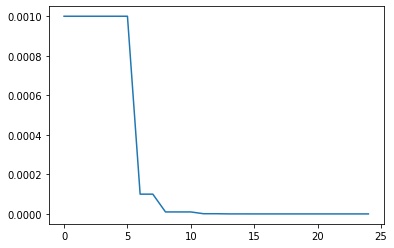

In [334]:
plt.plot(lrs)

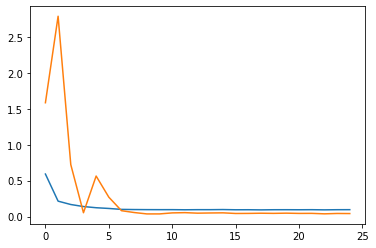

In [335]:
plt.plot(train_losses)
plt.plot(test_losses)

In [336]:
torch.save(best_weights, 'best_weights.pth')
model = StockPredictor(config, cat_dict).to(device)
model.load_state_dict(torch.load('best_weights.pth'))
model.eval()

StockPredictor(
  (emb_drop): Dropout(p=0.05, inplace=False)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(8, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=30102, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

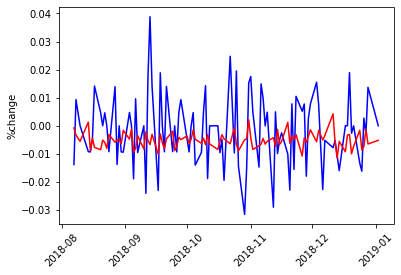

In [337]:
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
date_test = date_all[split:]

_=plt.plot(date_test[-100:],inv_true_pct.cpu().detach().numpy()[-100:],'b')
_=plt.plot(date_test[-100:],inv_pred_pct.cpu().detach().numpy()[-100:],'r')
_=plt.xticks(rotation=45)
_=plt.ylabel('%change')

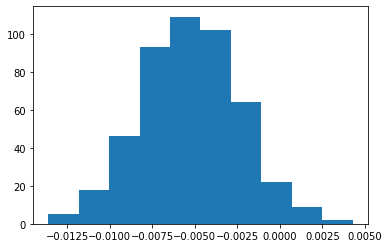

In [338]:
_ = plt.hist(inv_pred_pct.cpu().detach().numpy().squeeze())

In [339]:
y_pred = inv_pred_pct.cpu().detach().numpy().squeeze()
y_true = inv_true_pct.cpu().detach().numpy().squeeze()

In [340]:
y_true_bin = (y_true > 0).astype(float) #if the change is more than 0% it will be displayed as 1
y_pred_bin = (y_pred > 0).astype(float)

In [341]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [342]:
print(classification_report(y_true_bin, y_pred_bin))

              precision    recall  f1-score   support

         0.0       0.59      0.98      0.74       275
         1.0       0.57      0.04      0.08       195

    accuracy                           0.59       470
   macro avg       0.58      0.51      0.41       470
weighted avg       0.58      0.59      0.46       470



In [343]:
target

tensor([[0.5937],
        [0.6457],
        [0.5767],
        [0.6282],
        [0.6793],
        [0.6023],
        [0.6023],
        [0.6525],
        [0.5941],
        [0.5446],
        [0.5771],
        [0.6362],
        [0.6442],
        [0.5941],
        [0.5360],
        [0.6023],
        [0.5600],
        [0.5852],
        [0.5679],
        [0.6720],
        [0.6620],
        [0.6191],
        [0.5857],
        [0.5521],
        [0.6023],
        [0.6023],
        [0.5683],
        [0.6023],
        [0.5851],
        [0.6196],
        [0.5937],
        [0.6540],
        [0.6108],
        [0.5854],
        [0.6193],
        [0.5600],
        [0.6109],
        [0.6023],
        [0.6023],
        [0.6194],
        [0.6108],
        [0.5769],
        [0.5681],
        [0.6283],
        [0.6366],
        [0.6193],
        [0.6625],
        [0.6023],
        [0.6361],
        [0.5940],
        [0.5772],
        [0.5855],
        [0.4920],
        [0.6462],
        [0.6110],
        [0

In [344]:
# convert to price plot
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']

# to get real price is to multiply the predicted % with previous day close price


#prev_day_close is the current bug something went wrong in this line
#edit changed seq_input[:,-1,-2] to seq_input[:,-1,-4]
prev_day_close = seq_input[:,-1,-4]*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
#(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close'] THIS PART IS CORRECT



pred_price = (1+inv_pred_pct.view(-1,))*prev_day_close

inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
true_price = (1+inv_true_pct.view(-1,))*prev_day_close

In [345]:
prev_day_close[-1]

tensor(169.7910, device='cuda:0')

In [346]:
print(cat_input)

tensor([[ 30,   1,  30,  ...,   0,   0,   0],
        [  0,   2,  31,  ...,   0,   0,   0],
        [  1,   3,  32,  ...,   0,   0,   0],
        ...,
        [ 26,   3, 360,  ...,   0,   0,   0],
        [ 27,   4, 361,  ...,   0,   0,   0],
        [  1,   2,   1,  ...,   0,   0,   0]], device='cuda:0')


In [347]:
print(max_dict)

{'High': 252.0, 'Low': 249.0, 'Open': 251.0, 'Volume': 50325900.0, 'Adj Close': 217.6216278076172, 'SMA': 243.15, 't3': 248.98467811965895, 'pct_change': 0.12173908294157276}


In [348]:
print(min_dict)

{'High': 14.25, 'Low': 13.75, 'Open': 14.0, 'Volume': 0.0, 'Adj Close': 9.415380477905273, 'SMA': 14.675, 't3': 13.96983400555201, 'pct_change': -0.1843971402429766}


In [349]:
pred_price

tensor([165.5179, 166.1395, 167.6514, 166.3993, 167.1327, 171.3260, 171.8859,
        170.6839, 174.2073, 174.2510, 169.9875, 169.3842, 170.3574, 172.5425,
        173.3522, 168.7867, 169.3030, 167.0314, 166.8291, 164.3528, 168.5920,
        170.4441, 171.7865, 171.0319, 168.3821, 168.0339, 167.8895, 166.3036,
        166.2582, 166.7357, 166.9641, 165.9901, 169.0659, 168.1369, 168.3353,
        169.4129, 166.8452, 168.1130, 167.0235, 167.3683, 168.2446, 167.5285,
        167.5654, 165.4727, 167.8068, 168.2962, 170.4555, 173.1987, 173.5881,
        173.6096, 174.1173, 172.9511, 172.5419, 165.5858, 168.6950, 168.7907,
        165.2610, 164.5540, 165.4541, 164.1802, 165.0549, 166.5912, 169.4231,
        172.4336, 171.9933, 172.4455, 169.1071, 169.0308, 165.0905, 162.5440,
        165.1691, 165.3580, 166.4670, 169.2120, 170.7820, 169.3773, 168.6428,
        169.8019, 169.7325, 170.1469, 168.5675, 169.5256, 168.3474, 169.8658,
        169.6227, 167.9743, 167.8020, 169.0974, 169.5142, 171.32

In [350]:
true_price

tensor([166.0543, 168.2566, 166.9352, 168.2566, 172.2207, 172.2207, 172.2207,
        174.8635, 174.4230, 171.3398, 170.0184, 171.7802, 173.9826, 173.5421,
        170.0184, 170.0184, 167.8161, 166.9352, 165.1733, 168.6970, 171.7802,
        172.6612, 171.7802, 169.1375, 169.1375, 169.1375, 167.3756, 167.3756,
        166.4947, 167.3756, 166.9352, 169.5780, 170.0184, 169.1375, 170.0184,
        167.8161, 168.2566, 168.2566, 168.2566, 169.1375, 169.5780, 168.2566,
        166.4947, 167.8161, 169.5780, 170.4589, 173.5989, 173.5989, 175.3932,
        174.9446, 173.5989, 172.7018, 166.8703, 169.1131, 169.5617, 166.4217,
        165.9731, 165.9731, 164.6274, 165.9731, 167.7674, 169.5617, 173.1503,
        172.7018, 173.1503, 170.0103, 170.0103, 165.9731, 163.7302, 165.9731,
        165.9731, 167.7674, 170.9075, 171.8046, 170.9075, 170.4589, 170.4589,
        170.9074, 170.9075, 168.2160, 170.4589, 169.5617, 170.9074, 170.0103,
        168.6646, 168.6646, 169.5617, 170.4589, 171.8046, 172.25

In [352]:
#grabs the same amount of real price as pred price 
n_days = list(pred_price.shape)
n_days = n_days[0]
n_days = -n_days
# tensor_Close = torch.tensor(stock_data[0].iloc[n_days:,:]['Close'].values)
tensor_Close = torch.tensor(stock_data.iloc[n_days:,:]['Close'].values)
tensor_Close = tensor_Close.to(device)

In [353]:
F.mse_loss(true_price,pred_price).sqrt() #comparing pred price to true price

tensor(2.6805, device='cuda:0', grad_fn=<SqrtBackward>)

In [354]:
F.mse_loss(tensor_Close,pred_price).sqrt() #comparing pred price to actual price

tensor(21.1091, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)

NOTE: True price is only correct at the last 30 days becuase that's how it work, so don't pay too much attention to the actual price.

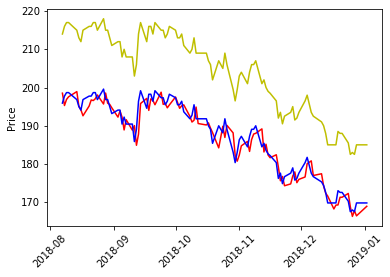

In [355]:
#graph of predicted and true closing price
_=plt.plot(date_test[-100:],tensor_Close.cpu().detach().numpy()[-100:],'y') #Actual
_=plt.plot(date_test[-100:],pred_price.cpu().detach().numpy()[-100:],'r') #Predict
_=plt.plot(date_test[-100:],true_price.cpu().detach().numpy()[-100:],'b') #True 
# _=plt.plot(date_test[-100:],true_price.cpu().detach().numpy()[-100:],'b') #True 
_=plt.xticks(rotation=45)
_=plt.ylabel('Price')

In [356]:
np.corrcoef(true_price.cpu().detach().numpy(),pred_price.cpu().detach().numpy())[0][1]

0.9825039343627585

# **Simulation**

In [357]:
cash = 1_000_000
port = 0
for pct_pred, pct_true in zip(inv_pred_pct.cpu().detach().numpy(),inv_true_pct.cpu().detach().numpy()):
  if pct_pred>0:
    #buy
    if port == 0:
      port=cash
      cash=0
  else:
    #sell
    if port != 0:
      cash=port
      port=0
  #realize
  if port != 0:
    port *= (1+pct_true)
  
equity = cash+port
print(equity)

[1088001.72429771]


In [358]:
min(date_test), max(date_test)

(Timestamp('2017-01-31 00:00:00'), Timestamp('2019-01-02 00:00:00'))

# **The added stuffs**

## export

In [359]:
model.parameters

<bound method Module.parameters of StockPredictor(
  (emb_drop): Dropout(p=0.05, inplace=False)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(8, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=30102, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)>

In [366]:
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [367]:
joblib.dump(model,'model_sma_t3.pkl')

['model_sma_t3.pkl']

In [362]:
# model_from_joblib = joblib.load('model_sma_t3.pkl')

In [363]:
# seq_input,cat_input,target = next(iter(test_dl))

In [364]:
# pred_pct1 = model_from_joblib(seq_input,cat_input)

In [365]:
# inv_pred_pct = pred_pct1*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
# inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
# date_test = date_all[split:]

# _=plt.plot(date_test[-100:],inv_true_pct.cpu().detach().numpy()[-100:],'b')
# _=plt.plot(date_test[-100:],inv_pred_pct.cpu().detach().numpy()[-100:],'r')
# _=plt.xticks(rotation=45)
# _=plt.ylabel('%change')